# File Information

Name: Amie Davis

Course: DSC630 - Predictive Analytics

Assignment Number: Final Project Part 4

Purpose: Build model(s)

Usage: Python 3.7.6

   Developed using Jupter Notebook 6.0.3

# Data Source
Uniform Crime Reporting Program Data: National Incident-Based Reporting System, [United States], 2016; United States Federal Bureau of Investigation; Inter-university Consortium for Political and Social Research (ICPSR), University of Michigan; https://www.icpsr.umich.edu/icpsrweb/NACJD/NIBRS/ 


Geodetic Data for US Cities: https://simplemaps.com/data/us-cities


# Part 4

In Part 4, I will build a decision tree classification models to predict the likelihood of specific offenses: justifiable homicide and aggrevated assualt.

## Import required packages

In [1]:
# Suppress Warnings
#import warnings
#warnings.filterwarnings('ignore') 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare Data

In [2]:
# Load data into dataframe
data_file = "Data\crime_offenses_top6.csv"    # Data from Top 6 States
df = pd.read_csv(data_file)

C:\Users\amomu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,11,14,15,16,17,18,19,41,42,44,46,51,52,53,54,56) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Eliminate features

In [3]:
print(df.columns)

Index(['Unnamed: 0', 'X1', 'ORI', 'INC_NUM', 'VIC_INC_DATE', 'VICTIM_TYPE',
       'ACT_TYPE_OFFC', 'ASSG_TYPE_OFFC', 'AGE_OF_VICTIM', 'SEX_OF_VICTIM',
       'RACE_OF_VICTIM', 'ETHNIC_OF_VIC', 'VIC_RESIDENT', 'ASSAULT_CIRC1',
       'ASSAULT_CIRC2', 'JUST_HOM_CIRC', 'INJURY_TYPE1', 'INJURY_TYPE2',
       'INJURY_TYPE3', 'INJURY_TYPE4', 'INJURY_TYPE5', 'NUM_RECS_PER_VICTIM',
       'VIC_INC_YEAR', 'VIC_INC_MONTH', 'VIC_INC_DAY', 'VIC_INC_DOW',
       'NUM_STATE_CODE', 'CITY', 'STATE', 'POP_GROUP', 'CTRY_DIVISION',
       'CTRY_REGION', 'AGENCY_IND', 'CORE_CITY', 'FBI_OFFICE', 'JUDICIAL_DIST',
       'CURRENT_POP1', 'UCR_COUNTY_CD1', 'MSA_CD1', 'LAST_POP1',
       'FIPS_COUNTY1', 'city_ascii', 'state_name', 'county_fips',
       'county_name', 'county_fips_all', 'county_name_all', 'lat', 'lng',
       'population', 'density', 'source', 'military', 'incorporated',
       'timezone', 'ranking', 'zips', 'id', 'OFF_CODE'],
      dtype='object')


In [4]:
# Remove irrelevant and redundant fields

# Drop unneeded columns
df.drop(['X1','id', 'county_fips', 'county_fips_all', 'Unnamed: 0', 
         'ORI', 'INC_NUM', 'NUM_RECS_PER_VICTIM', 'VIC_INC_DATE', 'VIC_INC_YEAR', 'VIC_INC_DAY',
         'ASSAULT_CIRC1', 'ASSAULT_CIRC2', 'JUST_HOM_CIRC', 
         'INJURY_TYPE1', 'INJURY_TYPE2', 'INJURY_TYPE3',
         'INJURY_TYPE4', 'INJURY_TYPE5', 'NUM_RECS_PER_VICTIM', 'AGENCY_IND',
         'FBI_OFFICE', 'JUDICIAL_DIST', 'FIPS_COUNTY1',
         'LAST_POP1', 'UCR_COUNTY_CD1', 'MSA_CD1', 'city_ascii', 'CITY', 'STATE',
         'state_name', 'county_name', 'county_name_all', 'population', 'zips',
         'source'], 
        axis=1, inplace = True)

# Also removing victim demograohics since they are not relevant to predict offenses and locations
df.drop(['VICTIM_TYPE','RACE_OF_VICTIM', 'AGE_OF_VICTIM', 
         'SEX_OF_VICTIM', 'ETHNIC_OF_VIC', 'VIC_RESIDENT'],
        axis=1, inplace = True)

# Verify Change
#print(df.columns)


In [5]:
# Replace NA values with NULL
df.replace('NA', np.nan)

# Remove Unknown Values with NULL
df.replace('U', np.nan)

# Drop columns with mostly NULL data
df.drop(['ACT_TYPE_OFFC','ASSG_TYPE_OFFC'],
        axis=1, inplace = True)

# Drop records with remaining null values
df.dropna(axis=0, inplace=True)

## Encoding

In [6]:
# Change DOW to numeric value
def f_dow(df):
    if df['VIC_INC_DOW'] == 'Sunday':
        val = 1
    elif df['VIC_INC_DOW'] == 'Monday':
        val = 2
    elif df['VIC_INC_DOW'] == 'Tuesday':
        val = 3
    elif df['VIC_INC_DOW'] == 'Wednesday':
        val = 4
    elif df['VIC_INC_DOW'] == 'Thursday':
        val = 5
    elif df['VIC_INC_DOW'] == 'Friday':
        val = 6
    elif df['VIC_INC_DOW'] == 'Saturday':
        val = 7
    else:
        val=0
    return val

# Change Timezone to numeric value
def f_tz(df):
    if df['timezone'] == 'America/New_York':
        val = 1
    elif df['timezone'] == 'America/Detroit':
        val = 2
    elif df['timezone'] == 'America/Chicago':
        val = 2
    elif df['timezone'] == 'America/Denver':
        val = 3
    elif df['timezone'] == 'America/Los_Angeles':
        val = 4
    else:
        val=0
    return val

# Convert simple categorical features to numeric to limit dummy features
df['VIC_INC_DOW'] = df.apply(f_dow, axis=1)
df['timezone'] = df.apply(f_tz, axis=1)

df['CORE_CITY'] = df['CORE_CITY'].map({'Y': 1, 'N': 0})
df['military'] = df['military'].map({True: 1, False: 0})
df['incorporated'] = df['incorporated'].map({True: 1, False: 0})

# Change target feature to easily translated numeric values
def f_off(df):
    if df['OFF_CODE'] == '09A':
        val = 91
    elif df['OFF_CODE'] == '09B':
        val = 92
    elif df['OFF_CODE'] == '09C':
        val = 93
    elif df['OFF_CODE'] == '100':
        val = 100
    elif df['OFF_CODE'] == '11A':
        val = 111
    elif df['OFF_CODE'] == '11B':
        val = 112
    elif df['OFF_CODE'] == '11C':
        val = 113
    elif df['OFF_CODE'] == '11D':
        val = 114
    elif df['OFF_CODE'] == '120':
        val = 120
    elif df['OFF_CODE'] == '13A':
        val = 131
    elif df['OFF_CODE'] == '13B':
        val = 132
    elif df['OFF_CODE'] == '13C':
        val = 133
    elif df['OFF_CODE'] == '200':
        val = 200
    elif df['OFF_CODE'] == '210':
        val = 210
    elif df['OFF_CODE'] == '220':
        val = 220
    elif df['OFF_CODE'] == '23A':
        val = 231
    elif df['OFF_CODE'] == '23B':
        val = 232
    elif df['OFF_CODE'] == '23C':
        val = 233
    elif df['OFF_CODE'] == '23D':
        val = 234
    elif df['OFF_CODE'] == '23E':
        val = 235
    elif df['OFF_CODE'] == '23F':
        val = 236
    elif df['OFF_CODE'] == '23G':
        val = 237
    elif df['OFF_CODE'] == '23H':
        val = 238
    elif df['OFF_CODE'] == '240':
        val = 240
    elif df['OFF_CODE'] == '250':
        val = 250
    elif df['OFF_CODE'] == '26A':
        val = 261
    elif df['OFF_CODE'] == '26B':
        val = 262
    elif df['OFF_CODE'] == '26C':
        val = 263
    elif df['OFF_CODE'] == '26D':
        val = 264
    elif df['OFF_CODE'] == '26E':
        val = 265
    elif df['OFF_CODE'] == '26F':
        val = 266
    elif df['OFF_CODE'] == '26G':
        val = 267
    elif df['OFF_CODE'] == '270':
        val = 270
    elif df['OFF_CODE'] == '280':
        val = 280
    elif df['OFF_CODE'] == '290':
        val = 290
    elif df['OFF_CODE'] == '35A':
        val = 351
    elif df['OFF_CODE'] == '35B':
        val = 352
    elif df['OFF_CODE'] == '36A':
        val = 361
    elif df['OFF_CODE'] == '36B':
        val = 362
    elif df['OFF_CODE'] == '370':
        val = 370
    elif df['OFF_CODE'] == '39A':
        val = 391
    elif df['OFF_CODE'] == '39B':
        val = 392
    elif df['OFF_CODE'] == '39C':
        val = 393
    elif df['OFF_CODE'] == '39D':
        val = 394
    elif df['OFF_CODE'] == '40A':
        val = 401
    elif df['OFF_CODE'] == '40B':
        val = 402
    elif df['OFF_CODE'] == '40C':
        val = 403
    elif df['OFF_CODE'] == '510':
        val = 510
    elif df['OFF_CODE'] == '520':
        val = 520
    elif df['OFF_CODE'] == '64A':
        val = 641
    elif df['OFF_CODE'] == '64B':
        val = 642
    elif df['OFF_CODE'] == '720':
        val = 720
    else:
        val=0
    return val  
df['OFF_CODE'] = df.apply(f_off, axis=1)

# Convert population group to easily translated numeric values
def f_pop(df):
    if df['POP_GROUP'] == '1A':
        val = 11
    elif df['POP_GROUP'] == '1B':
        val = 12
    elif df['POP_GROUP'] == '1C':
        val = 13
    elif df['POP_GROUP'] == '8A':
        val = 81
    elif df['POP_GROUP'] == '8B':
        val = 82
    elif df['POP_GROUP'] == '8C':
        val = 83
    elif df['POP_GROUP'] == '8D':
        val = 84
    elif df['POP_GROUP'] == '8E':
        val = 85
    elif df['POP_GROUP'] == '9A':
        val = 91
    elif df['POP_GROUP'] == '9B':
        val = 92
    elif df['POP_GROUP'] == '9C':
        val = 93
    elif df['POP_GROUP'] == '9D':
        val = 94
    elif df['POP_GROUP'] == '9E':
        val = 95
    else:
        val=df['POP_GROUP']
    return val  
df['POP_GROUP'] = df.apply(f_pop, axis=1)

In [7]:
# Use one-hot encoding on Offense Code to build models on specific codes
print('Data Before Encoding:')
print(df.OFF_CODE.head(8))
# Use One Hot Encoding to convert to binary matrix
data_cat_dummies = pd.get_dummies(df.OFF_CODE)
# Check the data
print()
print('Data After Encoding:')
print(data_cat_dummies.head(8))
print(data_cat_dummies.columns)
just_hom = data_cat_dummies[93]
agg_asst = data_cat_dummies[131]

Data Before Encoding:
0    261
1    237
2    133
3    238
4    290
5    233
6    233
7    233
Name: OFF_CODE, dtype: int64

Data After Encoding:
   91   92   93   100  111  112  113  114  120  131  ...  392  393  401  402  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
5    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
6    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
7    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   403  510  520  641  642  720  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0 

## Determine Target Variable

Use offense code as the target variable.  The goal is to be able to predict the likelihood of a specific offense code based on varying features.

For the first model, I will select Justifiable Homicide as the target variable.
A second model will predict Suspicious Activity.

## Split Datasets

In [8]:
# Split data into two sets: Training and Testing.

# Split out target variable
jh_model_y = just_hom
aa_model_y= agg_asst


# Remove target variable from feature list
data_model_X = df.drop(['OFF_CODE'], axis=1, inplace = False)

# Split the data into training and validation datasets
# Save 30% for validation
jh_X_train, jh_X_val, jh_y_train, jh_y_val = train_test_split(data_model_X, jh_model_y, test_size =0.3, random_state=7)
aa_X_train, aa_X_val, aa_y_train, aa_y_val = train_test_split(data_model_X, aa_model_y, test_size =0.3, random_state=7)

# Single Classification Models

## 1) Justifiable Homicide Model

### Build Decision Tree Model

In [9]:
# Create decision tree classifer object
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier(random_state=0, class_weight="balanced")
#decisiontree = DecisionTreeClassifier(random_state=0)

# Train model
jh_tree = decisiontree.fit(jh_X_train, jh_y_train)

### Model Evaluation

In [10]:
# Predict values
jh_y_pred = jh_tree.predict(jh_X_val)

In [11]:
# Create classification report
print(classification_report(jh_y_val, jh_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    595144
           1       0.00      0.25      0.01        16

    accuracy                           1.00    595160
   macro avg       0.50      0.62      0.50    595160
weighted avg       1.00      1.00      1.00    595160



### Confusion Matrix

C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


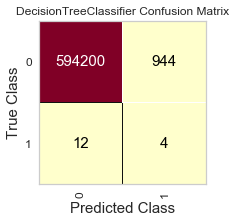

In [12]:
# Use Confusion Matrix to evaluate the model 

import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix

# Set up the figure size
plt.rcParams['figure.figsize'] = (3, 3)

classes = [0,1]
cm = ConfusionMatrix(jh_tree, classes=classes, percent=False)

# Fit the passed model
cm.fit(jh_X_train, jh_y_train)
  
# Score runs predict() and creates the confusion_matrix
cm.score(jh_X_val, jh_y_val)
       
# Change font for labels
for label in cm.ax.texts:
    label.set_size(15)

# Set label fonts
plt.xlabel('False Class',fontsize=15)
plt.ylabel('Predicted Class',fontsize=15)
    
# Draw plot
cm.poof()

#### Analysis - Justifiable Homicide
- Accuracy = (True Positives + True Negatives)/All
- Accuracy = (4+594200)/(594200+944+12+4)
- Accuracy = 99.8%

### Model Visualization

In [13]:
# Load libraries
import pydotplus
from IPython.display import Image
from sklearn import tree as sk_tree

feature_names = data_model_X.columns
target_name = 'JUST_HOMICIDE'

# Create DOT data
dot_data = sk_tree.export_graphviz(jh_tree,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=target_name)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

#Save graph
graph.write_png("jh_tree.png")

True

## 2) Aggravated Assault Model

### Build Model

In [14]:
# Create decision tree classifer object
from sklearn.tree import DecisionTreeClassifier
#decisiontree = DecisionTreeClassifier(random_state=0, class_weight="balanced")
decisiontree = DecisionTreeClassifier(random_state=0)

# Train model
aa_tree = decisiontree.fit(aa_X_train, aa_y_train)

### Model Evaluation

In [15]:
# Predict values
aa_y_pred = aa_tree.predict(aa_X_val)

In [16]:
# Create classification report
print(classification_report(aa_y_val, aa_y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    566569
           1       0.57      0.09      0.16     28591

    accuracy                           0.95    595160
   macro avg       0.76      0.54      0.57    595160
weighted avg       0.94      0.95      0.94    595160



### Confusion Matrix

C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


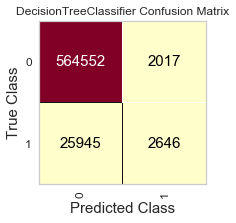

In [17]:
# Use Confusion Matrix to evaluate the model 

# Set up the figure size
plt.rcParams['figure.figsize'] = (3, 3)

classes = [0,1]
cm = ConfusionMatrix(aa_tree, classes=classes, percent=False)

# Fit the passed model
cm.fit(aa_X_train, aa_y_train)
  
# Score runs predict() and creates the confusion_matrix
cm.score(aa_X_val, aa_y_val)
       
# Change font for labels
for label in cm.ax.texts:
    label.set_size(15)

# Set label fonts
plt.xlabel('False Class',fontsize=15)
plt.ylabel('Predicted Class',fontsize=15)
    
# Draw plot
cm.poof()

#### Analysis - Aggrevated Assault
- Accuracy = (True Positives + True Negatives)/All
- Accuracy = (21129+409778)/(409778+156791+7462+21129)
- Accuracy = 72.4%

### Model Visualization

In [18]:
target_name = 'AGG_ASSAULT'

# Create DOT data
dot_data = sk_tree.export_graphviz(aa_tree,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=target_name)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

#Save graph
graph.write_png("aa_tree.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0164915 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0164915 to fit



True